In [1]:
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster import hierarchy
from scipy.spatial import distance

%matplotlib inline  

In [2]:
%run ../diff/chipseq_diff_plots.py

In [3]:
path = "/mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff"

output_path = "/mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed"

diffs_dict = {}

for mark in ['H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3', 'H3K36me3']:
    print(mark)
    out = os.path.join(output_path, mark)

    if os.path.exists(out):
        shutil.rmtree(out)
        os.mkdir(out)

    diffs = DiffProcessor(path, out, mark)
    diffs.collect_difference()
    
    diffs_dict[mark] = diffs 

H3K27ac
H3K27me3
H3K4me1
H3K4me3
H3K36me3


## H3K27ac

In [4]:
diffs = diffs_dict['H3K27ac']

In [5]:
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,diff_bind_zinbra_H3K27ac_dedup_TRUE_f_125_DBA_...,1,0,1
1,diff_bind_cons_zinbra_H3K27ac_dedup_TRUE_f_125...,1,0,1
2,chipdiff_H3K27ac,0,0,0
3,diff_OD_YD_H3K27ac_zinbra_200_0.01_0,45324,42941,2383
4,diff_OD_YD_H3K27ac_zinbra_200_0.01_5,41288,39038,2250
5,diff_OD_YD_H3K27ac_zinbra_200_0.01_10,38633,36467,2166
6,diff_OD_YD_H3K27ac_zinbra_200_1.0E-4_0,2192,2157,35
7,diff_OD_YD_H3K27ac_zinbra_200_1.0E-4_5,2049,2016,33
8,diff_OD_YD_H3K27ac_zinbra_200_1.0E-4_10,1998,1965,33
9,diff_OD_YD_H3K27ac_zinbra_200_1.0E-6_0,113,110,3


In [6]:
intersection = diffs.count_intersections()

/tmp/tmph_xxxrwp.tmp


In [7]:
def do_plot(metrics="jaccard", subset=None):
    matplotlib.rcParams['figure.figsize'] = (12,12)
    names = [n[:-9] for n in diffs.get_bed_files_produced()]
    
    files = diffs.get_bed_files_produced()
    
    if subset is not None:
        names = [n[:-9] for n in subset]
        files = subset

    sz = len(names)
    aa = np.zeros((sz, sz))

    for i1, f1 in enumerate(files):
        if (subset is not None) and (f1 not in subset):
            continue
        for i2, f2 in enumerate(files):
            if (subset is not None) and (f2 not in subset):
                continue
            if i1 == i2:
                aa[i1, i2] = 1.0
                continue
            t1 = intersection[(f1, f1)]
            t2 = intersection[(f2, f2)]
            i = intersection[(f1, f2)]
            
            if metrics=="jaccard":
                if (t1 + t2 - i) > 0:
                    aa[i1, i2] = i / (t1 + t2 - i)
                else:
                    aa[i1, i2] = 0.0
            else:
                if t1 > 0:
                    aa[i1, i2] = i / t1
                else:
                    aa[i1, i2] = 0.0
            
    if metrics=="jaccard":
        dissimilarity = distance.squareform(1 - aa)
        linkage = hierarchy.linkage(dissimilarity, method="single")    
        g = sns.clustermap(aa, row_linkage=linkage, col_linkage=linkage, cmap="rainbow", yticklabels=names)
    else:
        g = sns.clustermap(aa, cmap="rainbow", xticklabels=names, yticklabels=names)


    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)  # For y axis
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90) # For x axis

    plt.show()

In [8]:
def get_tool(name):
    if 'diff_bind' in name:
        return 'diff_bind'
    
    if 'diff_macs_pooled_Y_O' in name:
        return 'diff_macs_pooled_Y_O'
    
    if 'diff_macs_pooled' in name:
        return 'diff_macs_pooled'
    
    if 'median_consensus' in name:
        return 'median_consensus'
    
    if 'diffReps' in name:
        return 'diffReps'
    
    if 'zinbra' in name:
        return 'zinbra'
    
    return name

In [9]:
def print_best(metrics="jaccard"):
    names = [n[:-4] for n in diffs.get_bed_files_produced()]

    best = {}

    for f1 in diffs.get_bed_files_produced():
        for f2 in diffs.get_bed_files_produced():
            tool1 = get_tool(f1)
            tool2 = get_tool(f2)
            
            if tool1 == tool2: 
                continue
                
            if metrics=="jaccard" and tool1 > tool2:
                continue
            
            t1 = intersection[(f1, f1)]
            t2 = intersection[(f2, f2)]
            i = intersection[(f1, f2)]
            
            if metrics=="jaccard":
                if (t1 + t2 - i) > 0:
                    score = i / (t1 + t2 - i)
                else:
                    score = 0.0
            else:
                if t1 > 0:
                    score = i / t1
                else:
                    score = 0.0
                    
            if tool1 not in best:
                best[tool1] = {}
                        
            best1 = best[tool1]
            
            if tool2 not in best1:
                best1[tool2] = (None, None, -1)
            current = best1[tool2][2]
    
            if score > current:
                best1[tool2] = (f1, f2, score)
    
    data = []
    
    for tool1 in best:
        for tool2 in best[tool1]:
            f1, f2, score = best[tool1][tool2]
            data.append((f1, f2, score))
            
    s = sorted(data, key=lambda item: -item[2])    
    
    return pd.DataFrame.from_records(s, columns=["f1", "f2", "score"])

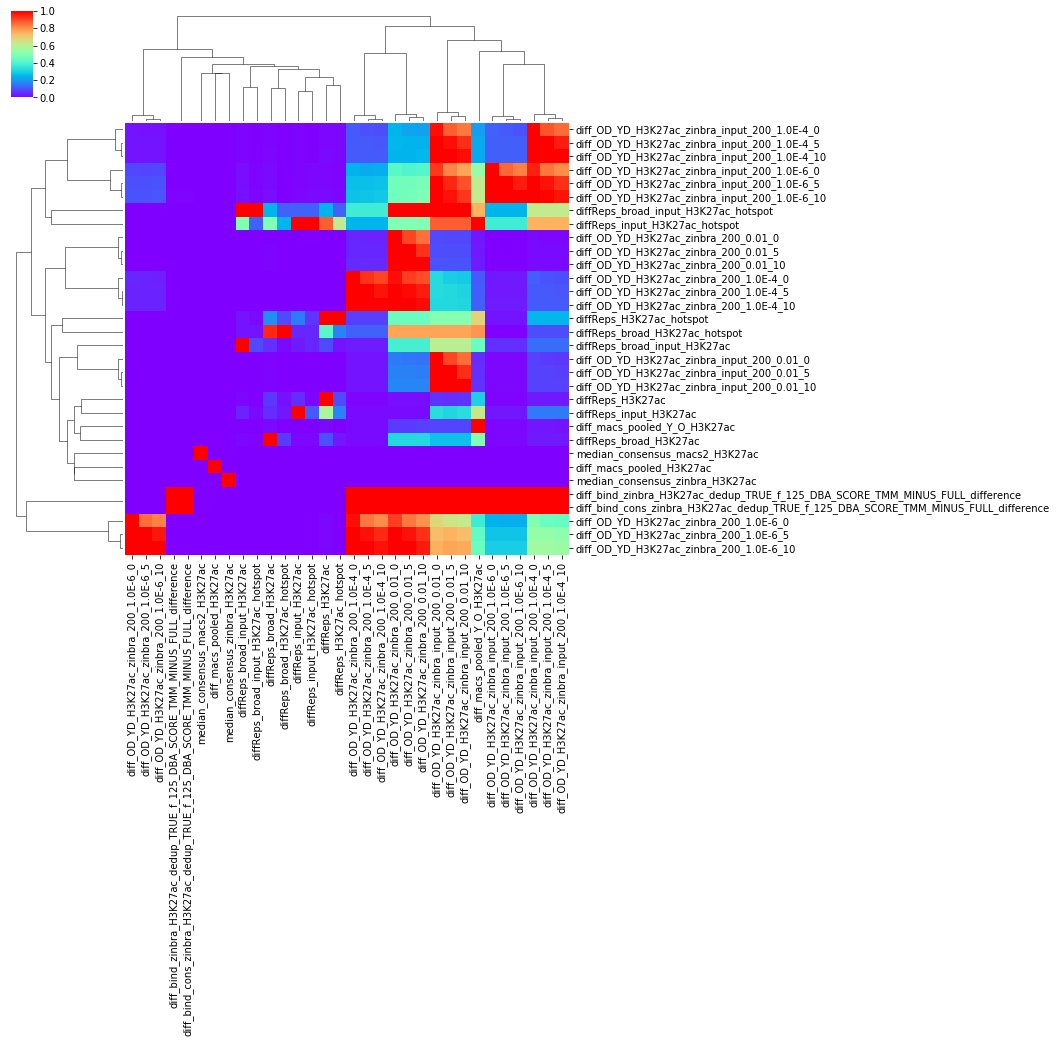

In [10]:
do_plot("m1")

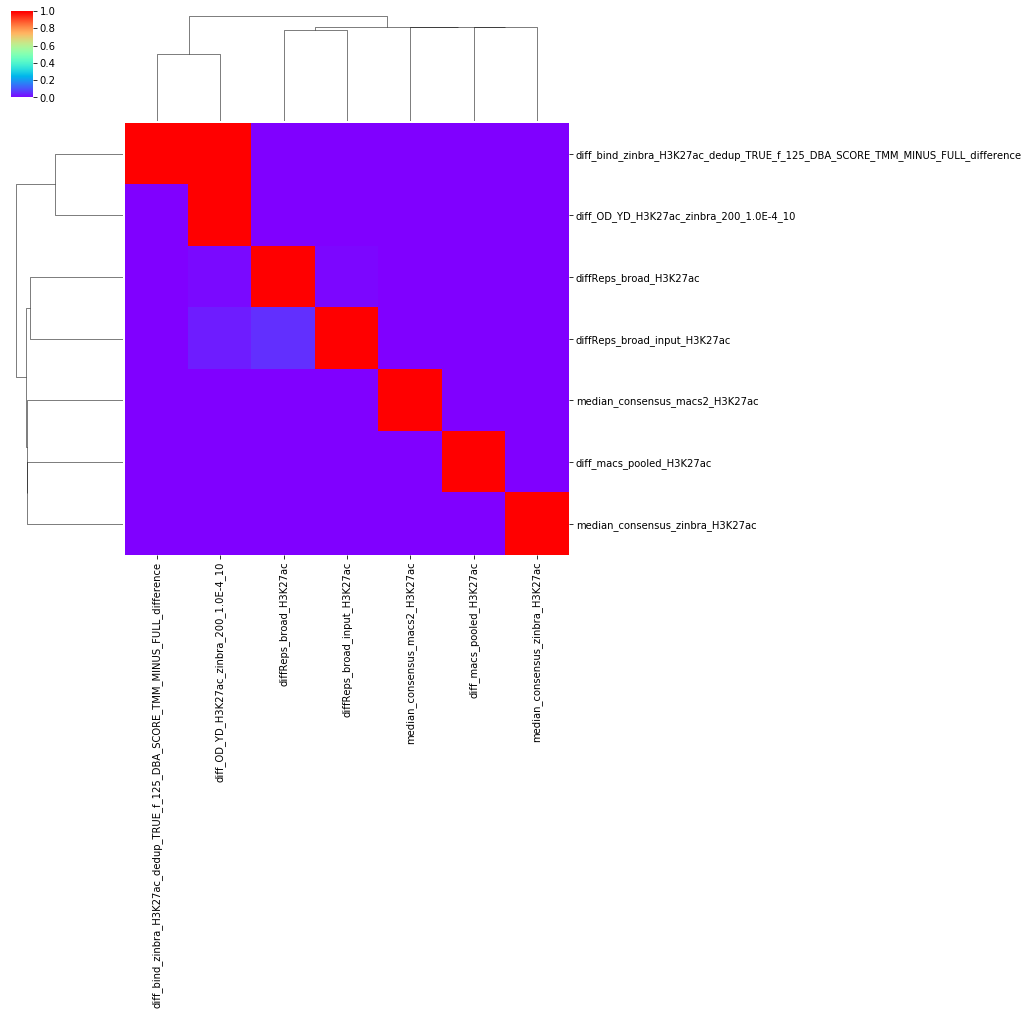

In [11]:
do_plot("m1", [
    "diff_bind_zinbra_H3K27ac_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_FULL_difference_both.bed",
    "diff_OD_YD_H3K27ac_zinbra_200_1.0E-4_10_both.bed",
    "diff_macs_pooled_H3K27ac_both.bed",
    "median_consensus_zinbra_H3K27ac_both.bed",
    "median_consensus_macs2_H3K27ac_both.bed",
    "diffReps_broad_H3K27ac_both.bed",
    "diffReps_broad_input_H3K27ac_both.bed"])

In [12]:
print_best("jaccard")

,f1,f2,score
0,diff_macs_pooled_Y_O_H3K27ac_both.bed,diff_OD_YD_H3K27ac_zinbra_input_200_0.01_10_bo...,0.039347
1,diffReps_broad_input_H3K27ac_both.bed,diff_OD_YD_H3K27ac_zinbra_input_200_1.0E-6_10_...,0.014970
2,diffReps_broad_H3K27ac_both.bed,diff_macs_pooled_Y_O_H3K27ac_both.bed,0.014374
3,diff_bind_zinbra_H3K27ac_dedup_TRUE_f_125_DBA_...,diff_OD_YD_H3K27ac_zinbra_input_200_1.0E-6_10_...,0.003937
4,diff_bind_zinbra_H3K27ac_dedup_TRUE_f_125_DBA_...,diff_macs_pooled_Y_O_H3K27ac_both.bed,0.000057
5,diffReps_H3K27ac_both.bed,median_consensus_zinbra_H3K27ac_both.bed,0.000000
6,diffReps_H3K27ac_both.bed,diff_bind_zinbra_H3K27ac_dedup_TRUE_f_125_DBA_...,0.000000
7,diffReps_H3K27ac_both.bed,diff_macs_pooled_H3K27ac_both.bed,0.000000
8,diff_bind_zinbra_H3K27ac_dedup_TRUE_f_125_DBA_...,median_consensus_zinbra_H3K27ac_both.bed,0.000000
9,diff_bind_zinbra_H3K27ac_dedup_TRUE_f_125_DBA_...,diff_macs_pooled_H3K27ac_both.bed,0.000000


In [13]:
print_best("m1")

,f1,f2,score
0,diff_bind_zinbra_H3K27ac_dedup_TRUE_f_125_DBA_...,diff_OD_YD_H3K27ac_zinbra_200_0.01_0_both.bed,1.000000
1,diff_bind_zinbra_H3K27ac_dedup_TRUE_f_125_DBA_...,diff_macs_pooled_Y_O_H3K27ac_both.bed,1.000000
2,diffReps_broad_input_H3K27ac_hotspot_both.bed,diff_OD_YD_H3K27ac_zinbra_200_0.01_0_both.bed,1.000000
3,diffReps_input_H3K27ac_hotspot_both.bed,diff_macs_pooled_Y_O_H3K27ac_both.bed,1.000000
4,diff_OD_YD_H3K27ac_zinbra_input_200_1.0E-6_10_...,diff_macs_pooled_Y_O_H3K27ac_both.bed,0.629921
5,diff_macs_pooled_Y_O_H3K27ac_both.bed,diff_OD_YD_H3K27ac_zinbra_input_200_0.01_0_bot...,0.089745
6,diff_OD_YD_H3K27ac_zinbra_input_200_1.0E-6_10_...,diffReps_broad_input_H3K27ac_both.bed,0.019685
7,diff_macs_pooled_Y_O_H3K27ac_both.bed,diffReps_broad_H3K27ac_both.bed,0.014576
8,diff_OD_YD_H3K27ac_zinbra_input_200_1.0E-6_10_...,diff_bind_zinbra_H3K27ac_dedup_TRUE_f_125_DBA_...,0.003937
9,diff_macs_pooled_Y_O_H3K27ac_both.bed,diff_bind_zinbra_H3K27ac_dedup_TRUE_f_125_DBA_...,0.000057


bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27ac/both/diff_macs_pooled_Y_O_H3K27ac_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27ac/both/diffReps_H3K27ac_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27ac/both/diff_OD_YD_H3K27ac_zinbra_200_1.0E-4_0_both.bed >/tmp/tmpjwxynba0.tmp/counts.bed


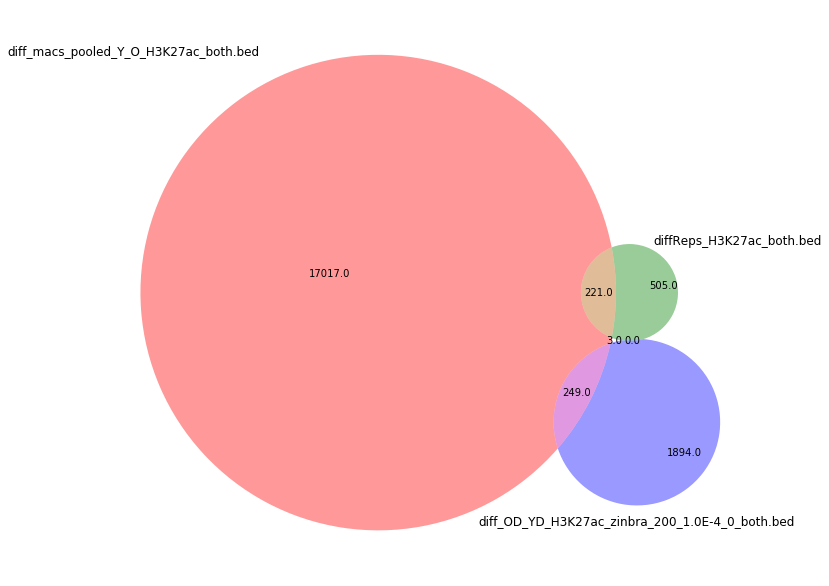

In [14]:
diffs.plot_venn3('diff_macs_pooled_Y_O_H3K27ac_both.bed', 
                 'diffReps_H3K27ac_both.bed', 
                 'diff_OD_YD_H3K27ac_zinbra_200_1.0E-4_0_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27ac/both/diffReps_broad_H3K27ac_hotspot_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27ac/both/diff_macs_pooled_Y_O_H3K27ac_both.bed >/tmp/tmpg3b1oj2_.tmp/counts.bed
0


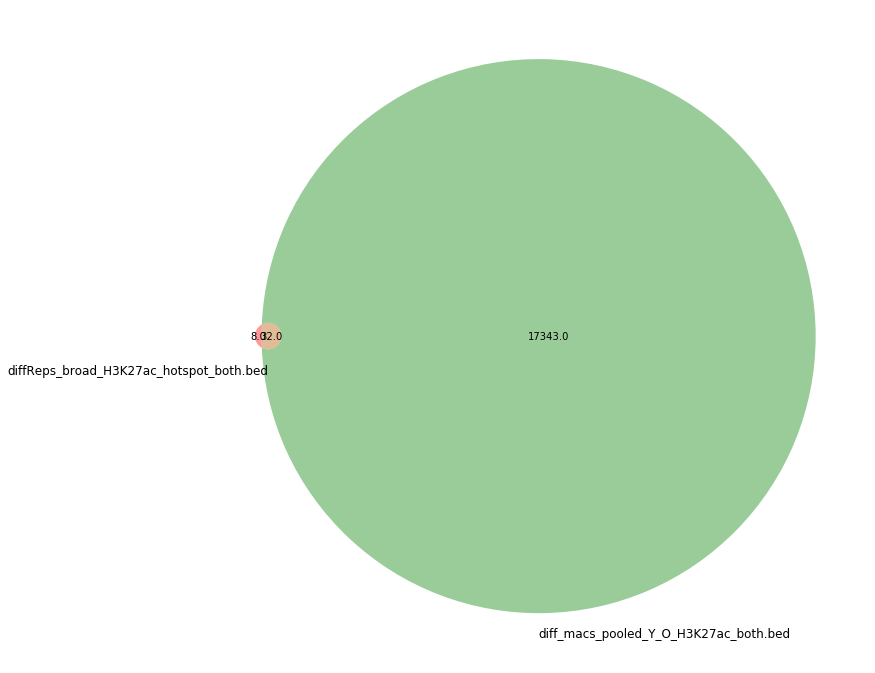

In [15]:
diffs.plot_venn2('diffReps_broad_H3K27ac_hotspot_both.bed', 'diff_macs_pooled_Y_O_H3K27ac_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27ac/both/diff_OD_YD_H3K27ac_zinbra_200_1.0E-6_10_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27ac/both/diff_macs_pooled_Y_O_H3K27ac_both.bed >/tmp/tmptmvcmww1.tmp/counts.bed
0


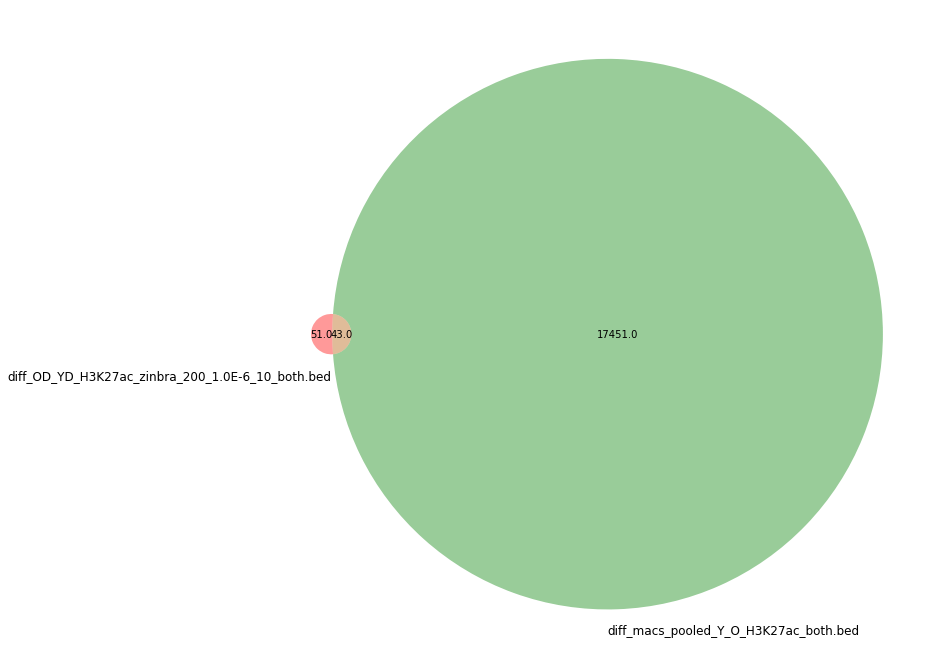

In [16]:
diffs.plot_venn2('diff_OD_YD_H3K27ac_zinbra_200_1.0E-6_10_both.bed', 
                 'diff_macs_pooled_Y_O_H3K27ac_both.bed')

# H3K27me3

In [17]:
diffs = diffs_dict['H3K27me3']

In [18]:
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,diff_bind_zinbra_H3K27me3_dedup_TRUE_f_125_DBA...,3,1,2
1,diff_bind_cons_zinbra_H3K27me3_dedup_TRUE_f_12...,1,0,1
2,chipdiff_H3K27me3,0,0,0
3,diff_OD_YD_H3K27me3_zinbra_200_0.01_0,20002,16576,3426
4,diff_OD_YD_H3K27me3_zinbra_200_0.01_5,19349,16001,3348
5,diff_OD_YD_H3K27me3_zinbra_200_0.01_10,18991,15692,3299
6,diff_OD_YD_H3K27me3_zinbra_200_1.0E-4_0,141,138,3
7,diff_OD_YD_H3K27me3_zinbra_200_1.0E-4_5,141,138,3
8,diff_OD_YD_H3K27me3_zinbra_200_1.0E-4_10,141,138,3
9,diff_OD_YD_H3K27me3_zinbra_200_1.0E-6_0,0,0,0


/tmp/tmpgkf7qsi3.tmp


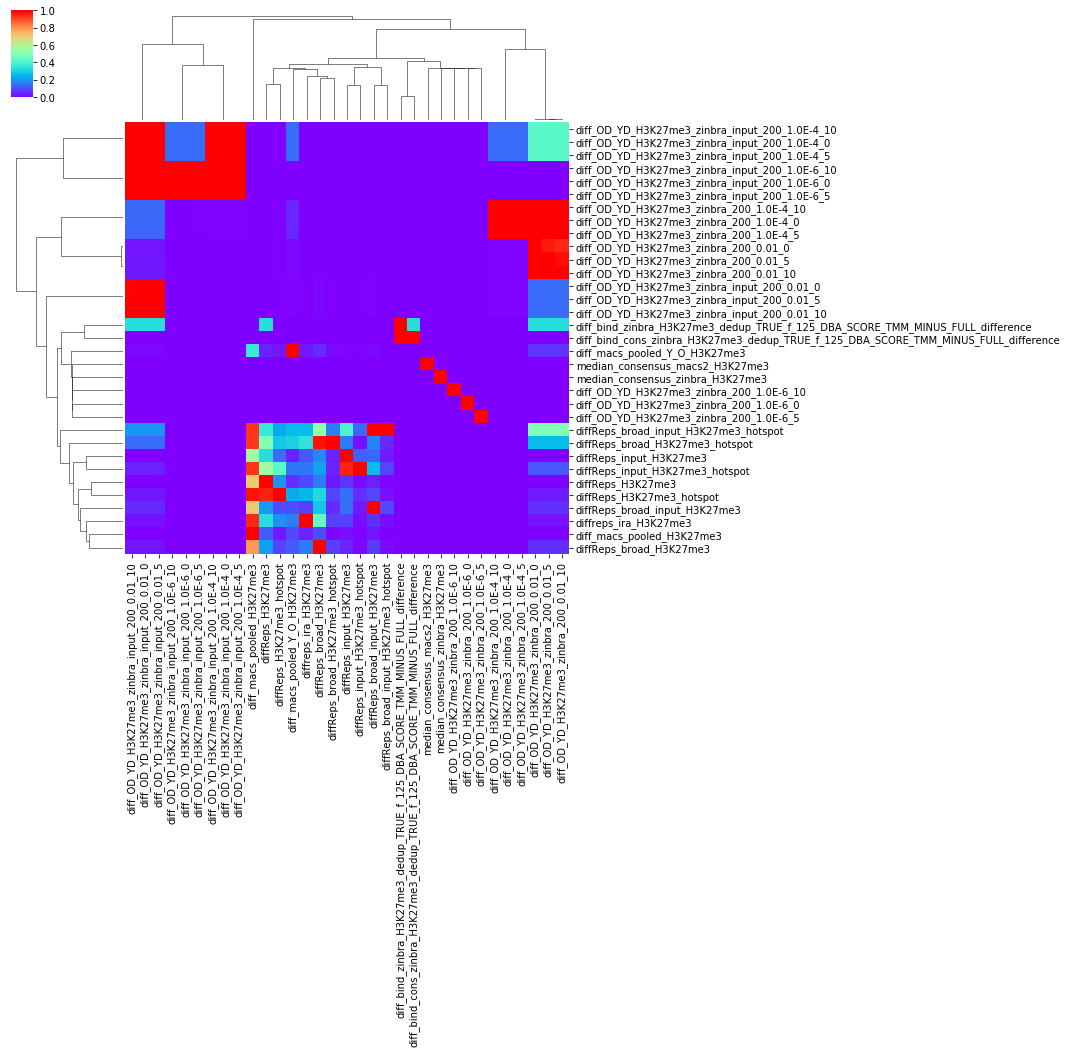

In [19]:
intersection = diffs.count_intersections()

do_plot("m1")

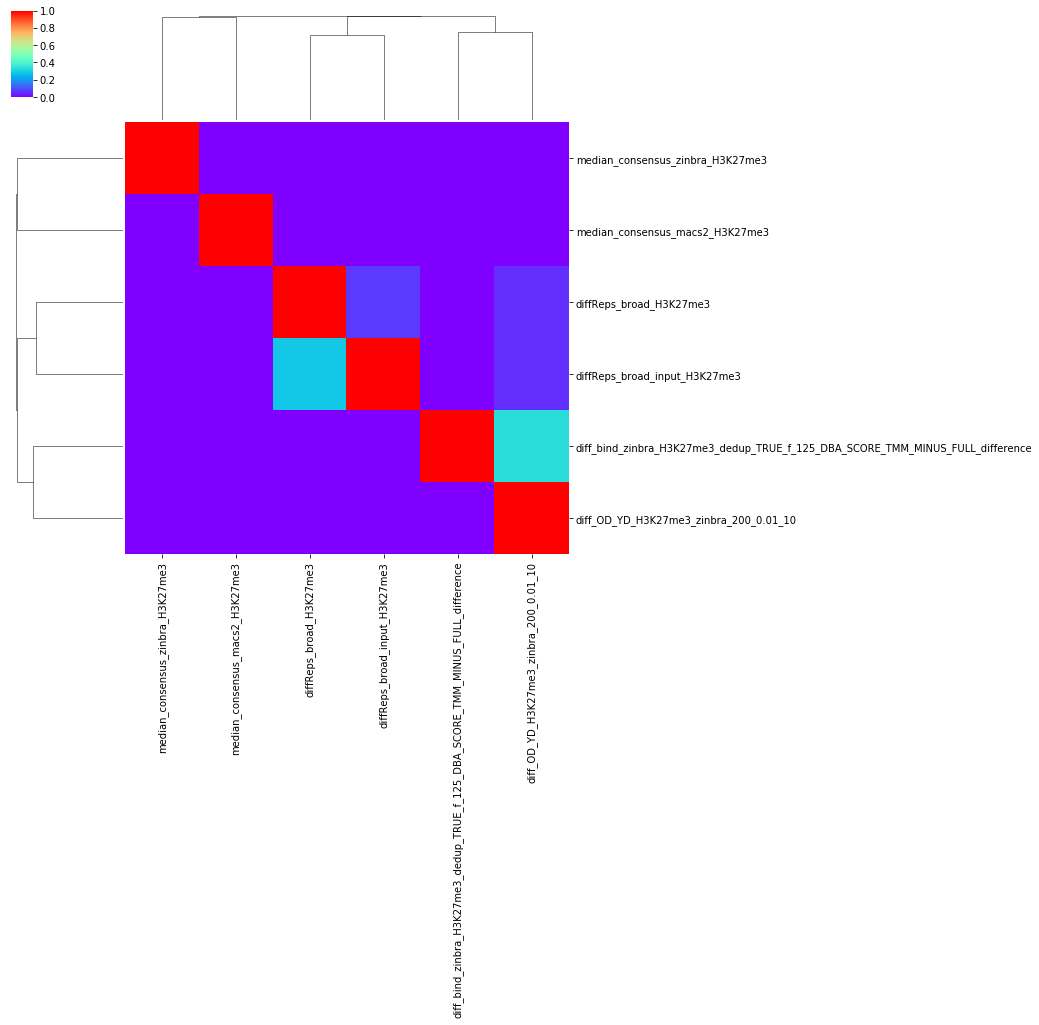

In [20]:
do_plot("m1", ['diff_bind_zinbra_H3K27me3_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_FULL_difference_both.bed',
               'diff_OD_YD_H3K27me3_zinbra_200_0.01_10_both.bed',
               'median_consensus_zinbra_H3K27me3_both.bed',
               'median_consensus_macs2_H3K27me3_both.bed',
               'diffReps_broad_H3K27me3_both.bed',
               'diffReps_broad_input_H3K27me3_both.bed'])


In [21]:
print_best("jaccard")

,f1,f2,score
0,diffReps_broad_H3K27me3_both.bed,diffreps_ira_H3K27me3_both.bed,0.135042
1,diffReps_H3K27me3_both.bed,diff_macs_pooled_H3K27me3_both.bed,0.113812
2,diff_macs_pooled_H3K27me3_both.bed,diff_macs_pooled_Y_O_H3K27me3_both.bed,0.080550
3,diff_macs_pooled_H3K27me3_both.bed,diffreps_ira_H3K27me3_both.bed,0.043529
4,diffReps_broad_H3K27me3_both.bed,diff_macs_pooled_Y_O_H3K27me3_both.bed,0.040741
5,diff_macs_pooled_Y_O_H3K27me3_both.bed,diffreps_ira_H3K27me3_both.bed,0.025969
6,diff_macs_pooled_Y_O_H3K27me3_both.bed,diff_OD_YD_H3K27me3_zinbra_200_0.01_10_both.bed,0.007424
7,diffReps_broad_H3K27me3_both.bed,diff_OD_YD_H3K27me3_zinbra_input_200_0.01_10_b...,0.006124
8,diffreps_ira_H3K27me3_both.bed,diff_OD_YD_H3K27me3_zinbra_input_200_0.01_10_b...,0.002318
9,diffReps_H3K27me3_both.bed,diff_bind_zinbra_H3K27me3_dedup_TRUE_f_125_DBA...,0.000625


In [22]:
print_best("m1")

,f1,f2,score
0,diffReps_H3K27me3_hotspot_both.bed,diff_macs_pooled_H3K27me3_both.bed,0.978395
1,diffreps_ira_H3K27me3_both.bed,diff_macs_pooled_H3K27me3_both.bed,0.951724
2,diffReps_broad_input_H3K27me3_hotspot_both.bed,diff_OD_YD_H3K27me3_zinbra_200_0.01_0_both.bed,0.500000
3,diffreps_ira_H3K27me3_both.bed,diffReps_broad_H3K27me3_both.bed,0.448276
4,diff_macs_pooled_Y_O_H3K27me3_both.bed,diff_macs_pooled_H3K27me3_both.bed,0.363414
5,diffReps_broad_H3K27me3_hotspot_both.bed,diffreps_ira_H3K27me3_both.bed,0.346939
6,diff_bind_zinbra_H3K27me3_dedup_TRUE_f_125_DBA...,diffReps_H3K27me3_both.bed,0.333333
7,diff_bind_zinbra_H3K27me3_dedup_TRUE_f_125_DBA...,diff_OD_YD_H3K27me3_zinbra_200_0.01_0_both.bed,0.333333
8,diffReps_broad_H3K27me3_hotspot_both.bed,diff_macs_pooled_Y_O_H3K27me3_both.bed,0.306122
9,diffreps_ira_H3K27me3_both.bed,diff_macs_pooled_Y_O_H3K27me3_both.bed,0.167816


bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27me3/both/diff_OD_YD_H3K27me3_zinbra_200_0.01_10_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27me3/both/diff_macs_pooled_H3K27me3_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27me3/both/diffReps_H3K27me3_both.bed >/tmp/tmpk2x4yody.tmp/counts.bed


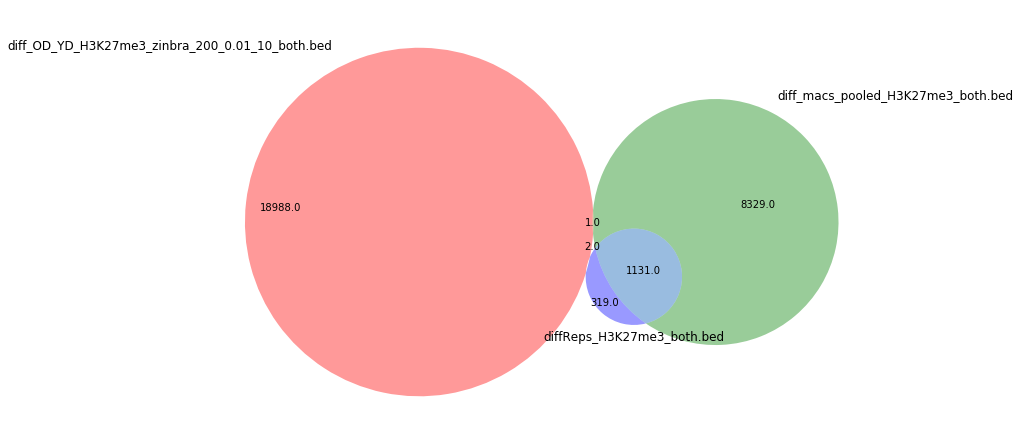

In [23]:
diffs.plot_venn3('diff_OD_YD_H3K27me3_zinbra_200_0.01_10_both.bed', 
                 'diff_macs_pooled_H3K27me3_both.bed',
                 'diffReps_H3K27me3_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27me3/both/diff_macs_pooled_H3K27me3_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27me3/both/diffReps_H3K27me3_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27me3/both/diffReps_broad_H3K27me3_both.bed >/tmp/tmp8ws7p9vg.tmp/counts.bed


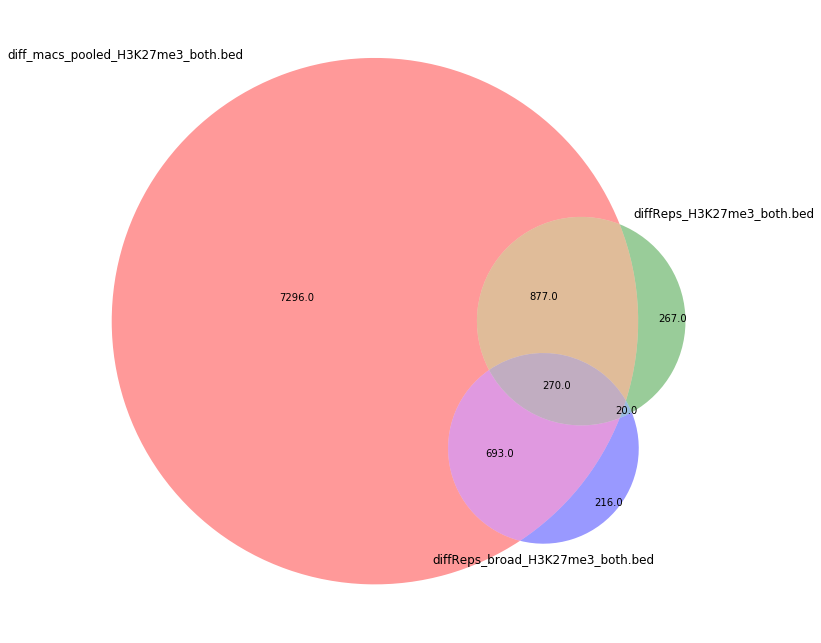

In [24]:
diffs.plot_venn3('diff_macs_pooled_H3K27me3_both.bed',
                 'diffReps_H3K27me3_both.bed',
                 'diffReps_broad_H3K27me3_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27me3/both/diff_macs_pooled_H3K27me3_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27me3/both/diffReps_H3K27me3_both.bed >/tmp/tmp6odemxg2.tmp/counts.bed
0


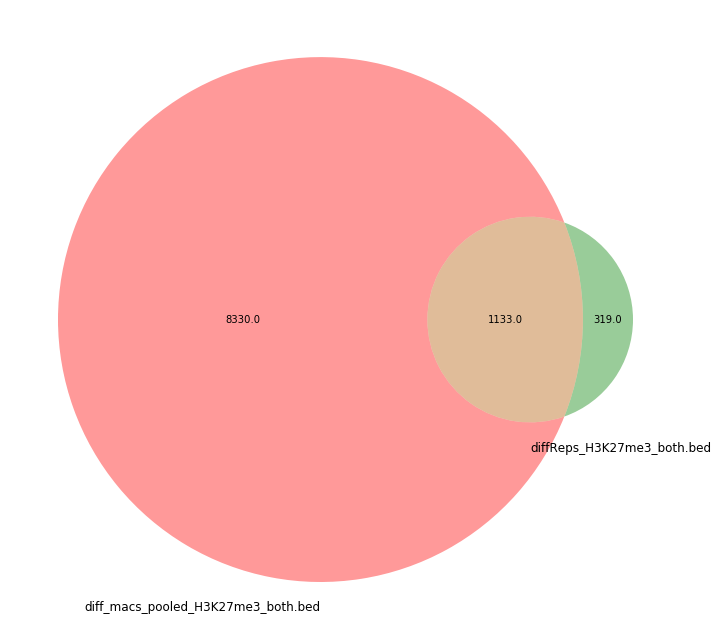

In [25]:
diffs.plot_venn2('diff_macs_pooled_H3K27me3_both.bed',
                 'diffReps_H3K27me3_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27me3/both/diffreps_ira_H3K27me3_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27me3/both/diffReps_broad_input_H3K27me3_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27me3/both/diffReps_broad_H3K27me3_both.bed >/tmp/tmp8m83mr17.tmp/counts.bed


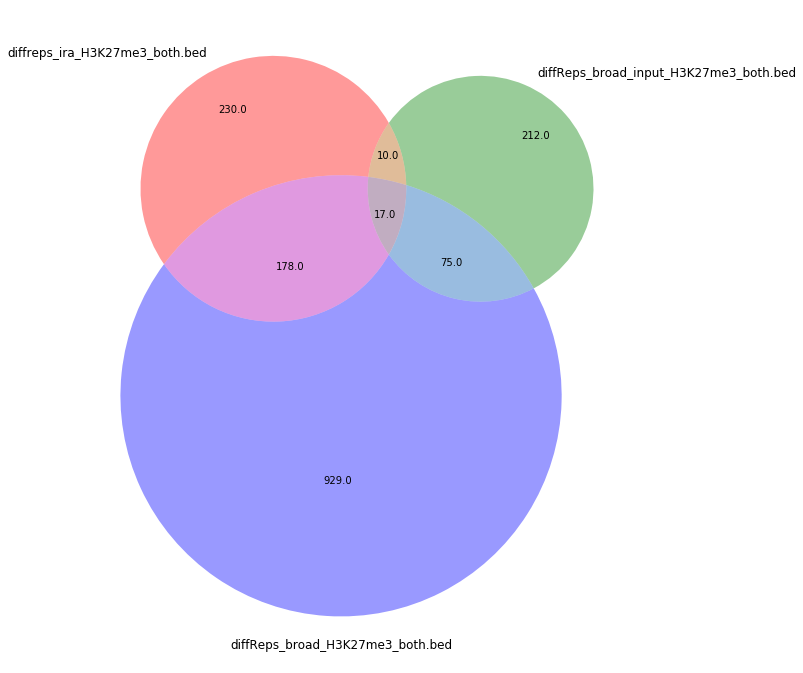

In [26]:
diffs.plot_venn3('diffreps_ira_H3K27me3_both.bed', 
                 'diffReps_broad_input_H3K27me3_both.bed',
                 'diffReps_broad_H3K27me3_both.bed')

## H3K4me1

In [27]:
diffs = diffs_dict['H3K4me1']
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,diff_bind_zinbra_H3K4me1_dedup_TRUE_f_125_DBA_...,2,0,2
1,diff_bind_cons_zinbra_H3K4me1_dedup_TRUE_f_125...,2,0,2
2,chipdiff_H3K4me1,0,0,0
3,diff_OD_YD_H3K4me1_zinbra_200_0.01_0,28879,13446,15433
4,diff_OD_YD_H3K4me1_zinbra_200_0.01_5,27479,12727,14752
5,diff_OD_YD_H3K4me1_zinbra_200_0.01_10,26656,12331,14325
6,diff_OD_YD_H3K4me1_zinbra_200_1.0E-4_0,1894,883,1011
7,diff_OD_YD_H3K4me1_zinbra_200_1.0E-4_5,1847,864,983
8,diff_OD_YD_H3K4me1_zinbra_200_1.0E-4_10,1831,859,972
9,diff_OD_YD_H3K4me1_zinbra_200_1.0E-6_0,96,41,55


/tmp/tmplcjcg_fp.tmp


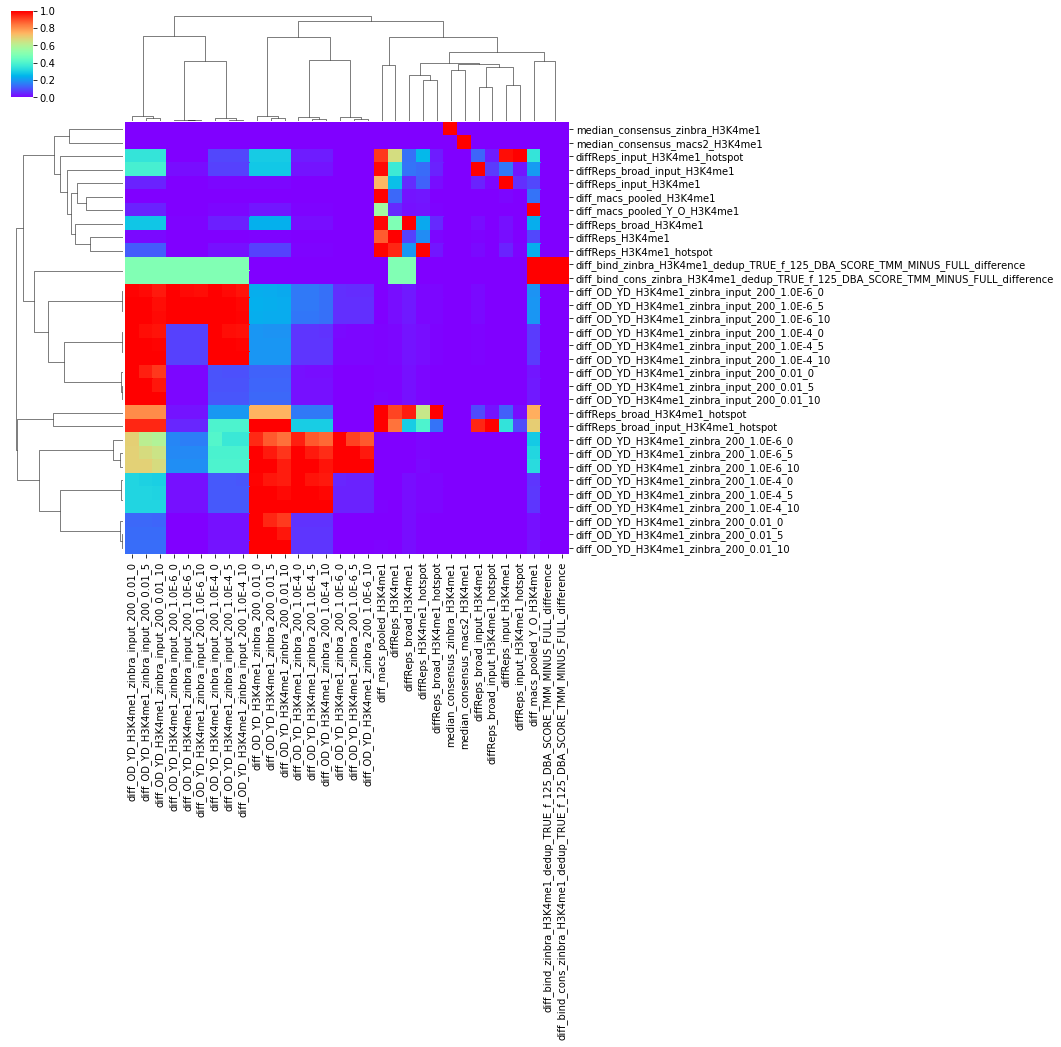

In [28]:
intersection = diffs.count_intersections()

do_plot("m1")

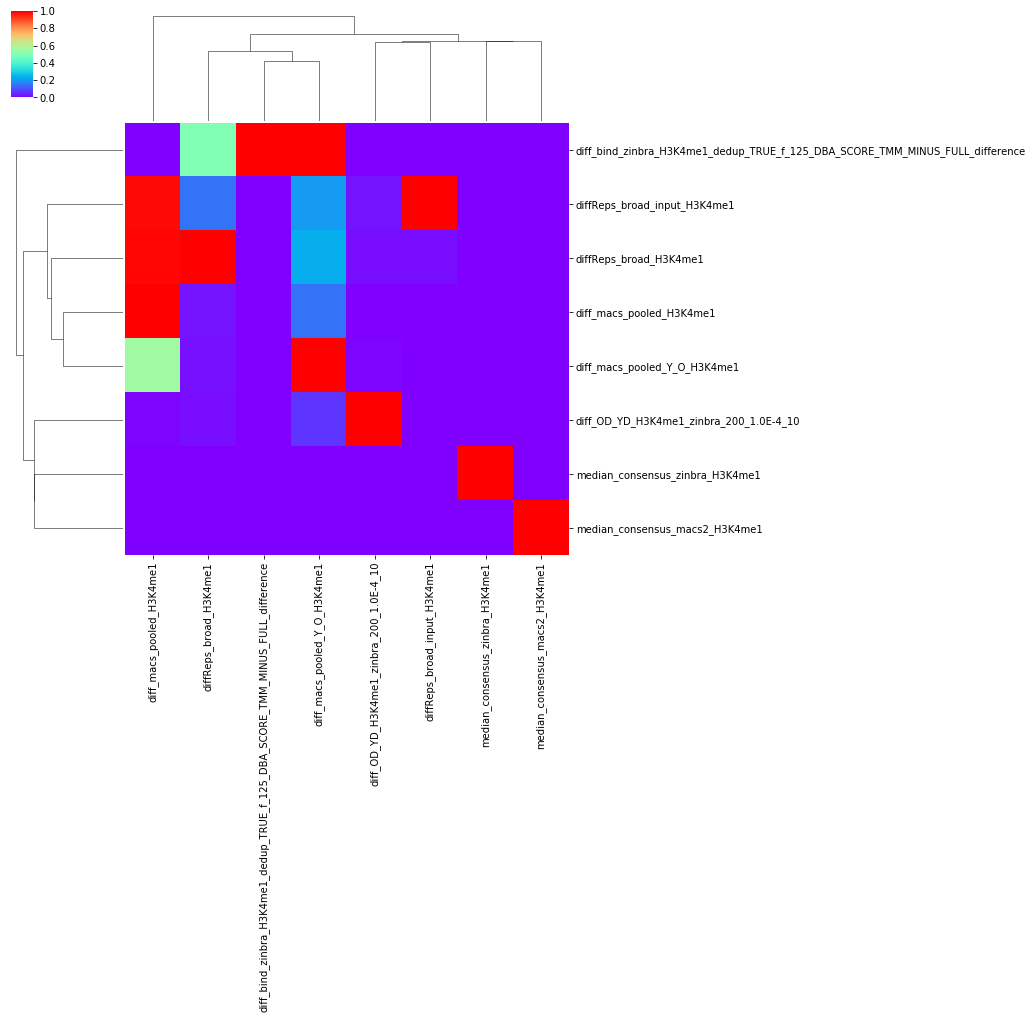

In [29]:
do_plot("m1", ['diff_bind_zinbra_H3K4me1_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_FULL_difference_both.bed',               
               'diff_OD_YD_H3K4me1_zinbra_200_1.0E-4_10_both.bed',
               'median_consensus_zinbra_H3K4me1_both.bed',
               'median_consensus_macs2_H3K4me1_both.bed',
               'diffReps_broad_H3K4me1_both.bed',
               'diffReps_broad_input_H3K4me1_both.bed',
               'diff_macs_pooled_H3K4me1_both.bed',
               'diff_macs_pooled_Y_O_H3K4me1_both.bed'])

In [30]:
print_best("jaccard")

,f1,f2,score
0,diff_macs_pooled_H3K4me1_both.bed,diff_macs_pooled_Y_O_H3K4me1_both.bed,0.135611
1,diffReps_H3K4me1_both.bed,diff_macs_pooled_H3K4me1_both.bed,0.131539
2,diffReps_H3K4me1_both.bed,diff_macs_pooled_Y_O_H3K4me1_both.bed,0.034321
3,diffReps_broad_H3K4me1_both.bed,diff_OD_YD_H3K4me1_zinbra_input_200_0.01_10_bo...,0.020018
4,diff_macs_pooled_Y_O_H3K4me1_both.bed,diff_OD_YD_H3K4me1_zinbra_input_200_0.01_10_bo...,0.019946
5,diff_bind_zinbra_H3K4me1_dedup_TRUE_f_125_DBA_...,diff_OD_YD_H3K4me1_zinbra_input_200_1.0E-6_10_...,0.003690
6,diff_macs_pooled_H3K4me1_both.bed,diff_OD_YD_H3K4me1_zinbra_input_200_0.01_10_bo...,0.002433
7,diffReps_broad_H3K4me1_both.bed,diff_bind_zinbra_H3K4me1_dedup_TRUE_f_125_DBA_...,0.000479
8,diff_bind_zinbra_H3K4me1_dedup_TRUE_f_125_DBA_...,diff_macs_pooled_Y_O_H3K4me1_both.bed,0.000091
9,diffReps_H3K4me1_both.bed,median_consensus_zinbra_H3K4me1_both.bed,0.000000


In [31]:
print_best("m1")

,f1,f2,score
0,diff_bind_zinbra_H3K4me1_dedup_TRUE_f_125_DBA_...,diff_macs_pooled_Y_O_H3K4me1_both.bed,1.000000
1,diffReps_broad_input_H3K4me1_hotspot_both.bed,diff_OD_YD_H3K4me1_zinbra_200_0.01_0_both.bed,1.000000
2,diffReps_broad_H3K4me1_hotspot_both.bed,diff_macs_pooled_H3K4me1_both.bed,1.000000
3,diffReps_broad_H3K4me1_hotspot_both.bed,diff_macs_pooled_Y_O_H3K4me1_both.bed,0.761062
4,diff_macs_pooled_Y_O_H3K4me1_both.bed,diff_macs_pooled_H3K4me1_both.bed,0.565879
5,diff_bind_zinbra_H3K4me1_dedup_TRUE_f_125_DBA_...,diffReps_H3K4me1_both.bed,0.500000
6,diff_bind_zinbra_H3K4me1_dedup_TRUE_f_125_DBA_...,diff_OD_YD_H3K4me1_zinbra_input_200_0.01_0_bot...,0.500000
7,diff_OD_YD_H3K4me1_zinbra_200_1.0E-6_10_both.bed,diff_macs_pooled_Y_O_H3K4me1_both.bed,0.329412
8,diff_macs_pooled_H3K4me1_both.bed,diff_macs_pooled_Y_O_H3K4me1_both.bed,0.151358
9,diff_macs_pooled_H3K4me1_both.bed,diffReps_H3K4me1_both.bed,0.133890


In [32]:
diffs.get_bed_files_produced()

['diff_bind_zinbra_H3K4me1_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_FULL_difference_both.bed',
 'diff_bind_cons_zinbra_H3K4me1_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_FULL_difference_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_0.01_0_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_0.01_5_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_0.01_10_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_1.0E-4_0_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_1.0E-4_5_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_1.0E-4_10_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_1.0E-6_0_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_1.0E-6_5_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_1.0E-6_10_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_input_200_0.01_0_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_input_200_0.01_5_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_input_200_0.01_10_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_input_200_1.0E-4_0_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_input_200_1.0E-4_5_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_input_200_1.0E-4_10_both.bed',
 'di

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K4me1/both/diff_OD_YD_H3K4me1_zinbra_200_1.0E-4_5_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K4me1/both/diff_macs_pooled_Y_O_H3K4me1_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K4me1/both/diffReps_H3K4me1_both.bed >/tmp/tmpxs7ja_5i.tmp/counts.bed


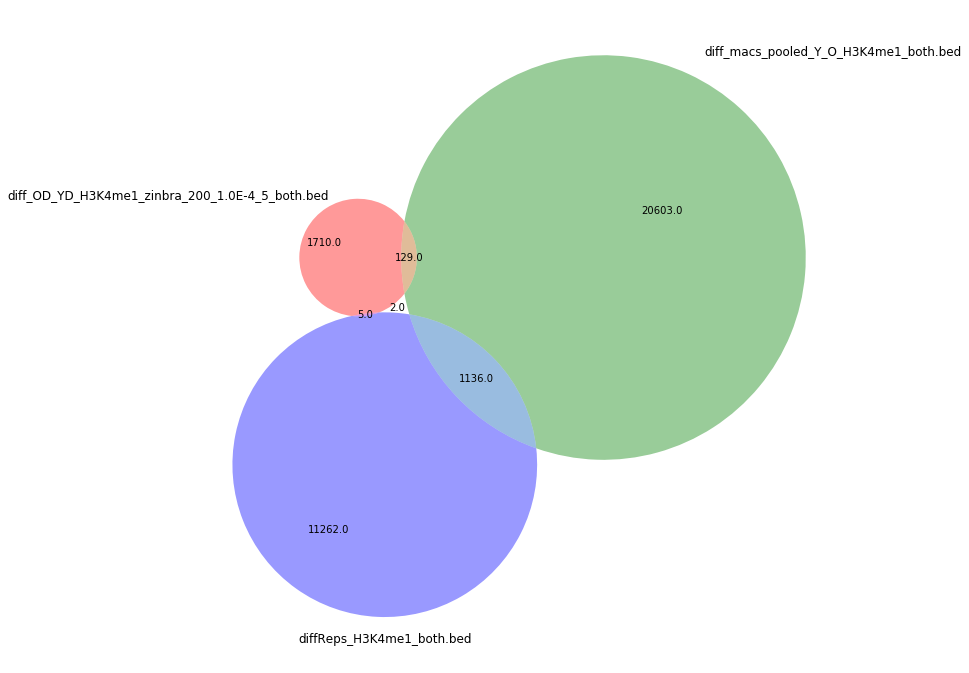

In [33]:
diffs.plot_venn3('diff_OD_YD_H3K4me1_zinbra_200_1.0E-4_5_both.bed', 
                 'diff_macs_pooled_Y_O_H3K4me1_both.bed',
                 'diffReps_H3K4me1_both.bed')

## H3K4me3

In [34]:
diffs = diffs_dict['H3K4me3']
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,diff_bind_zinbra_H3K4me3_dedup_TRUE_f_125_DBA_...,3,2,1
1,diff_bind_cons_zinbra_H3K4me3_dedup_TRUE_f_125...,5,5,0
2,chipdiff_H3K4me3,0,0,0
3,diff_OD_YD_H3K4me3_zinbra_200_0.01_0,4112,3567,545
4,diff_OD_YD_H3K4me3_zinbra_200_0.01_5,4097,3553,544
5,diff_OD_YD_H3K4me3_zinbra_200_0.01_10,4089,3545,544
6,diff_OD_YD_H3K4me3_zinbra_200_1.0E-4_0,3,3,0
7,diff_OD_YD_H3K4me3_zinbra_200_1.0E-4_5,2,2,0
8,diff_OD_YD_H3K4me3_zinbra_200_1.0E-4_10,1,1,0
9,diff_OD_YD_H3K4me3_zinbra_200_1.0E-6_0,0,0,0


/tmp/tmp_8xt1exf.tmp


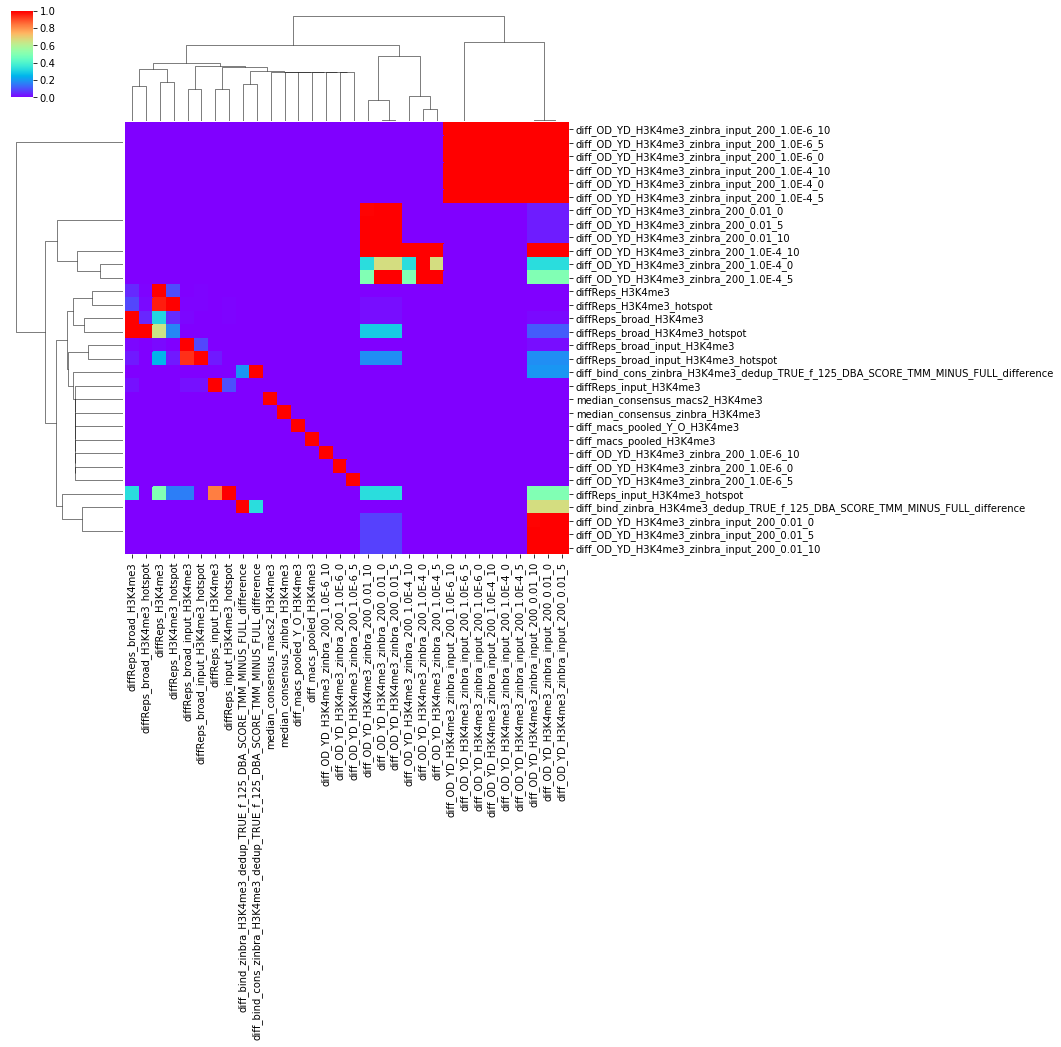

In [35]:
intersection = diffs.count_intersections()

do_plot("m1")

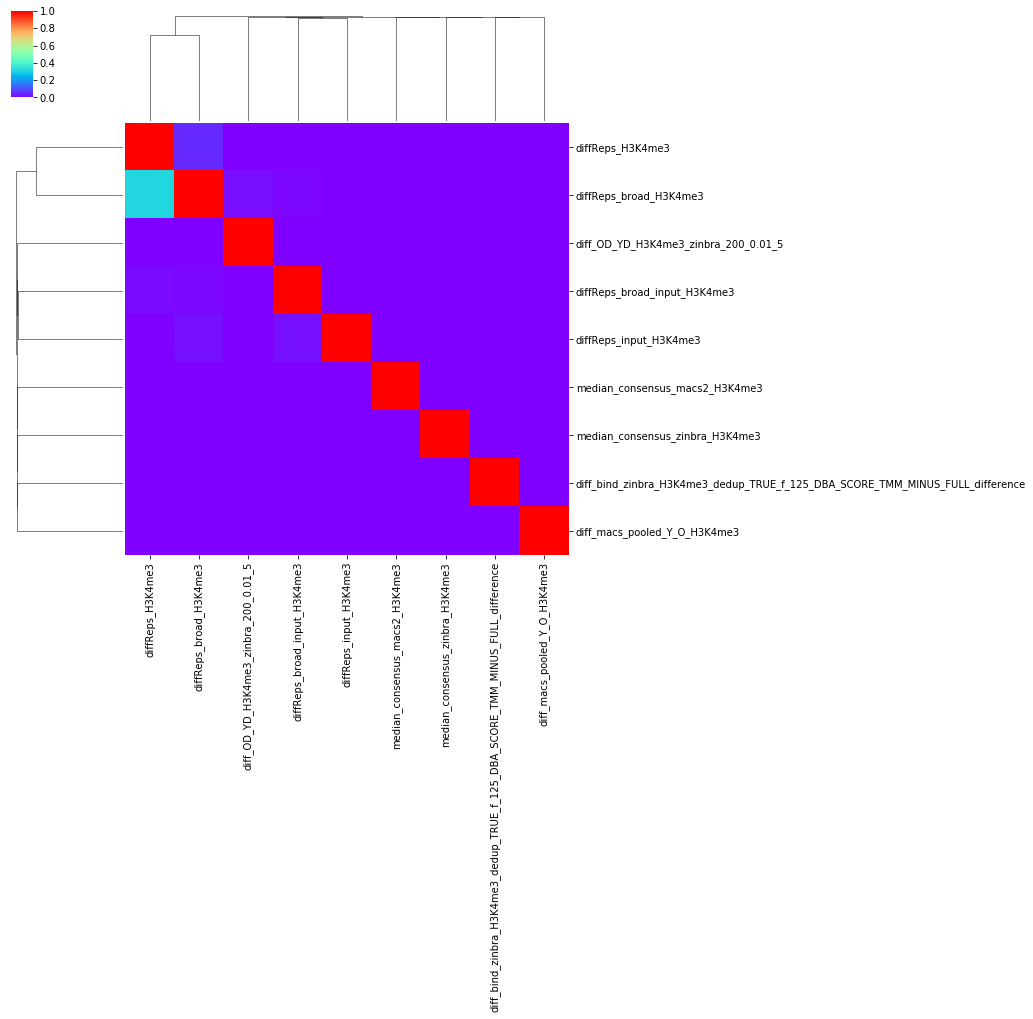

In [36]:
do_plot("m1", ['diff_bind_zinbra_H3K4me3_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_FULL_difference_both.bed',         
               'diff_OD_YD_H3K4me3_zinbra_200_0.01_5_both.bed',
               'diff_macs_pooled_Y_O_H3K4me3_both.bed',
               'median_consensus_zinbra_H3K4me3_both.bed',
               'median_consensus_macs2_H3K4me3_both.bed',
               'diffReps_H3K4me3_both.bed',
               'diffReps_broad_H3K4me3_both.bed',
               'diffReps_broad_input_H3K4me3_both.bed',
               'diffReps_input_H3K4me3_both.bed'])

In [37]:
print_best("jaccard")

,f1,f2,score
0,diffReps_broad_input_H3K4me3_hotspot_both.bed,diff_OD_YD_H3K4me3_zinbra_input_200_0.01_10_bo...,0.003478
1,diff_bind_zinbra_H3K4me3_dedup_TRUE_f_125_DBA_...,diff_OD_YD_H3K4me3_zinbra_input_200_0.01_10_bo...,0.001176
2,diffReps_H3K4me3_both.bed,median_consensus_zinbra_H3K4me3_both.bed,0.000000
3,diffReps_H3K4me3_both.bed,diff_bind_zinbra_H3K4me3_dedup_TRUE_f_125_DBA_...,0.000000
4,diffReps_H3K4me3_both.bed,diff_macs_pooled_Y_O_H3K4me3_both.bed,0.000000
5,diffReps_H3K4me3_both.bed,diff_macs_pooled_H3K4me3_both.bed,0.000000
6,diff_bind_zinbra_H3K4me3_dedup_TRUE_f_125_DBA_...,median_consensus_zinbra_H3K4me3_both.bed,0.000000
7,diff_bind_zinbra_H3K4me3_dedup_TRUE_f_125_DBA_...,diff_macs_pooled_Y_O_H3K4me3_both.bed,0.000000
8,diff_bind_zinbra_H3K4me3_dedup_TRUE_f_125_DBA_...,diff_macs_pooled_H3K4me3_both.bed,0.000000
9,median_consensus_zinbra_H3K4me3_both.bed,diff_OD_YD_H3K4me3_zinbra_200_0.01_0_both.bed,0.000000


In [38]:
print_best("m1")

,f1,f2,score
0,diff_bind_zinbra_H3K4me3_dedup_TRUE_f_125_DBA_...,diff_OD_YD_H3K4me3_zinbra_input_200_0.01_0_bot...,0.666667
1,diffReps_input_H3K4me3_hotspot_both.bed,diff_OD_YD_H3K4me3_zinbra_input_200_0.01_0_bot...,0.500000
2,diff_OD_YD_H3K4me3_zinbra_input_200_0.01_10_bo...,diffReps_broad_input_H3K4me3_both.bed,0.003531
3,diff_OD_YD_H3K4me3_zinbra_input_200_0.01_10_bo...,diff_bind_zinbra_H3K4me3_dedup_TRUE_f_125_DBA_...,0.001177
4,diff_bind_zinbra_H3K4me3_dedup_TRUE_f_125_DBA_...,diffReps_H3K4me3_both.bed,0.000000
5,diff_bind_zinbra_H3K4me3_dedup_TRUE_f_125_DBA_...,median_consensus_zinbra_H3K4me3_both.bed,0.000000
6,diff_bind_zinbra_H3K4me3_dedup_TRUE_f_125_DBA_...,diff_macs_pooled_Y_O_H3K4me3_both.bed,0.000000
7,diff_bind_zinbra_H3K4me3_dedup_TRUE_f_125_DBA_...,diff_macs_pooled_H3K4me3_both.bed,0.000000
8,median_consensus_zinbra_H3K4me3_both.bed,diffReps_H3K4me3_both.bed,0.000000
9,median_consensus_zinbra_H3K4me3_both.bed,diff_bind_zinbra_H3K4me3_dedup_TRUE_f_125_DBA_...,0.000000


In [39]:
diffs.get_bed_files_produced()

['diff_bind_zinbra_H3K4me3_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_FULL_difference_both.bed',
 'diff_bind_cons_zinbra_H3K4me3_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_FULL_difference_both.bed',
 'diff_OD_YD_H3K4me3_zinbra_200_0.01_0_both.bed',
 'diff_OD_YD_H3K4me3_zinbra_200_0.01_5_both.bed',
 'diff_OD_YD_H3K4me3_zinbra_200_0.01_10_both.bed',
 'diff_OD_YD_H3K4me3_zinbra_200_1.0E-4_0_both.bed',
 'diff_OD_YD_H3K4me3_zinbra_200_1.0E-4_5_both.bed',
 'diff_OD_YD_H3K4me3_zinbra_200_1.0E-4_10_both.bed',
 'diff_OD_YD_H3K4me3_zinbra_200_1.0E-6_0_both.bed',
 'diff_OD_YD_H3K4me3_zinbra_200_1.0E-6_5_both.bed',
 'diff_OD_YD_H3K4me3_zinbra_200_1.0E-6_10_both.bed',
 'diff_OD_YD_H3K4me3_zinbra_input_200_0.01_0_both.bed',
 'diff_OD_YD_H3K4me3_zinbra_input_200_0.01_5_both.bed',
 'diff_OD_YD_H3K4me3_zinbra_input_200_0.01_10_both.bed',
 'diff_OD_YD_H3K4me3_zinbra_input_200_1.0E-4_0_both.bed',
 'diff_OD_YD_H3K4me3_zinbra_input_200_1.0E-4_5_both.bed',
 'diff_OD_YD_H3K4me3_zinbra_input_200_1.0E-4_10_both.bed',
 'di

## H3K36me3

In [40]:
diffs = diffs_dict['H3K36me3']
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,chipdiff_H3K36me3,0,0,0
1,diff_OD_YD_H3K36me3_zinbra_200_0.01_0,50474,7086,43388
2,diff_OD_YD_H3K36me3_zinbra_200_0.01_5,47017,6639,40378
3,diff_OD_YD_H3K36me3_zinbra_200_0.01_10,44304,6275,38029
4,diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_0,2444,214,2230
5,diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_5,2403,212,2191
6,diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_10,2379,212,2167
7,diff_OD_YD_H3K36me3_zinbra_200_1.0E-6_0,64,1,63
8,diff_OD_YD_H3K36me3_zinbra_200_1.0E-6_5,47,1,46
9,diff_OD_YD_H3K36me3_zinbra_200_1.0E-6_10,38,1,37


/tmp/tmpwp_e4ldh.tmp


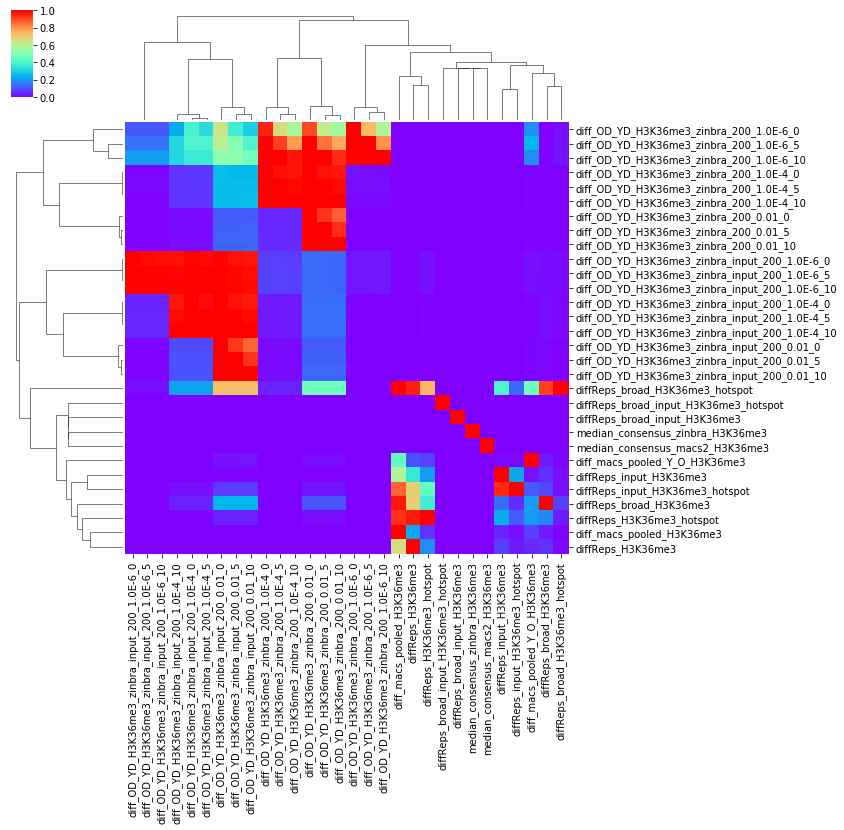

In [41]:
intersection = diffs.count_intersections()

do_plot("m1")

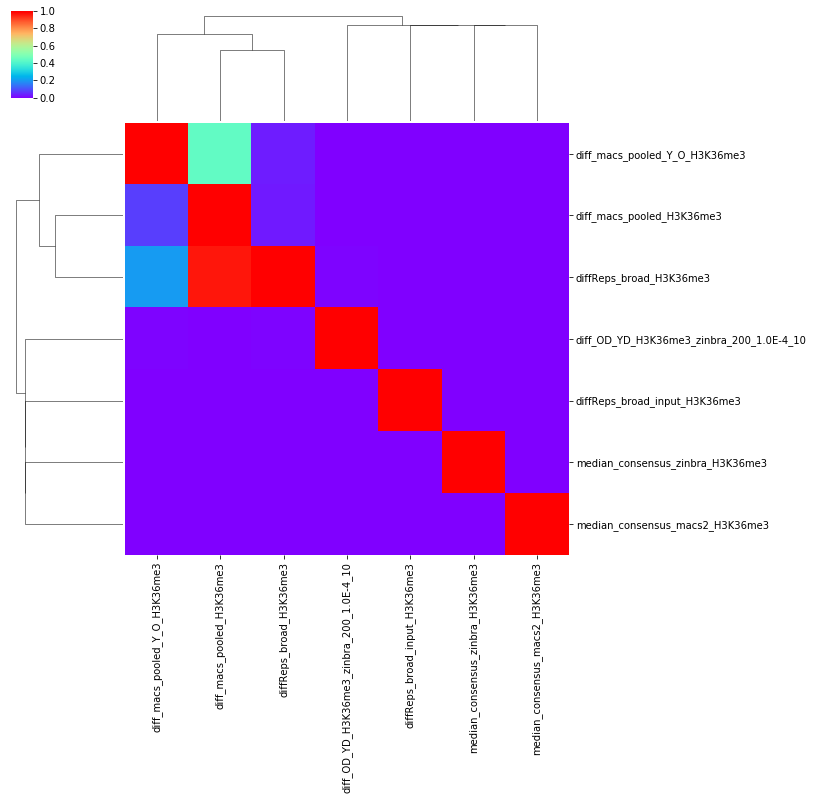

In [42]:
do_plot("m1", ['diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_10_both.bed',
               'diff_macs_pooled_H3K36me3_both.bed',
               'diff_macs_pooled_Y_O_H3K36me3_both.bed',
               'median_consensus_zinbra_H3K36me3_both.bed',
               'median_consensus_macs2_H3K36me3_both.bed',
               'diffReps_broad_H3K36me3_both.bed',
               'diffReps_broad_input_H3K36me3_both.bed'])


In [43]:
print_best("jaccard")

,f1,f2,score
0,diffReps_H3K36me3_both.bed,diff_macs_pooled_H3K36me3_both.bed,0.207907
1,diff_macs_pooled_H3K36me3_both.bed,diff_macs_pooled_Y_O_H3K36me3_both.bed,0.071983
2,diffReps_H3K36me3_hotspot_both.bed,diff_macs_pooled_Y_O_H3K36me3_both.bed,0.060698
3,diffReps_broad_H3K36me3_both.bed,diff_OD_YD_H3K36me3_zinbra_input_200_1.0E-4_10...,0.012402
4,diff_macs_pooled_Y_O_H3K36me3_both.bed,diff_OD_YD_H3K36me3_zinbra_input_200_0.01_10_b...,0.004554
5,diff_macs_pooled_H3K36me3_both.bed,diff_OD_YD_H3K36me3_zinbra_input_200_0.01_10_b...,0.001736
6,diffReps_H3K36me3_both.bed,median_consensus_zinbra_H3K36me3_both.bed,0.000000
7,median_consensus_zinbra_H3K36me3_both.bed,diff_OD_YD_H3K36me3_zinbra_200_0.01_0_both.bed,0.000000
8,diff_macs_pooled_Y_O_H3K36me3_both.bed,median_consensus_zinbra_H3K36me3_both.bed,0.000000
9,diff_macs_pooled_H3K36me3_both.bed,median_consensus_zinbra_H3K36me3_both.bed,0.000000


In [44]:
print_best("m1")

,f1,f2,score
0,diffReps_broad_H3K36me3_hotspot_both.bed,diff_macs_pooled_H3K36me3_both.bed,1.000000
1,diffReps_broad_H3K36me3_hotspot_both.bed,diff_OD_YD_H3K36me3_zinbra_input_200_0.01_0_bo...,0.728324
2,diffReps_broad_H3K36me3_hotspot_both.bed,diff_macs_pooled_Y_O_H3K36me3_both.bed,0.468208
3,diff_macs_pooled_Y_O_H3K36me3_both.bed,diff_macs_pooled_H3K36me3_both.bed,0.441796
4,diff_OD_YD_H3K36me3_zinbra_200_1.0E-6_5_both.bed,diff_macs_pooled_Y_O_H3K36me3_both.bed,0.255319
5,diff_macs_pooled_H3K36me3_both.bed,diffReps_H3K36me3_both.bed,0.232663
6,diff_macs_pooled_Y_O_H3K36me3_both.bed,diffReps_H3K36me3_both.bed,0.106892
7,diff_macs_pooled_H3K36me3_both.bed,diff_macs_pooled_Y_O_H3K36me3_both.bed,0.079185
8,diff_OD_YD_H3K36me3_zinbra_200_1.0E-6_10_both.bed,diffReps_broad_H3K36me3_hotspot_both.bed,0.026316
9,diff_macs_pooled_Y_O_H3K36me3_both.bed,diff_OD_YD_H3K36me3_zinbra_input_200_0.01_10_b...,0.023743


In [45]:
diffs.get_bed_files_produced()

['diff_OD_YD_H3K36me3_zinbra_200_0.01_0_both.bed',
 'diff_OD_YD_H3K36me3_zinbra_200_0.01_5_both.bed',
 'diff_OD_YD_H3K36me3_zinbra_200_0.01_10_both.bed',
 'diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_0_both.bed',
 'diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_5_both.bed',
 'diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_10_both.bed',
 'diff_OD_YD_H3K36me3_zinbra_200_1.0E-6_0_both.bed',
 'diff_OD_YD_H3K36me3_zinbra_200_1.0E-6_5_both.bed',
 'diff_OD_YD_H3K36me3_zinbra_200_1.0E-6_10_both.bed',
 'diff_OD_YD_H3K36me3_zinbra_input_200_0.01_0_both.bed',
 'diff_OD_YD_H3K36me3_zinbra_input_200_0.01_5_both.bed',
 'diff_OD_YD_H3K36me3_zinbra_input_200_0.01_10_both.bed',
 'diff_OD_YD_H3K36me3_zinbra_input_200_1.0E-4_0_both.bed',
 'diff_OD_YD_H3K36me3_zinbra_input_200_1.0E-4_5_both.bed',
 'diff_OD_YD_H3K36me3_zinbra_input_200_1.0E-4_10_both.bed',
 'diff_OD_YD_H3K36me3_zinbra_input_200_1.0E-6_0_both.bed',
 'diff_OD_YD_H3K36me3_zinbra_input_200_1.0E-6_5_both.bed',
 'diff_OD_YD_H3K36me3_zinbra_input_200_1.0E-6_10_both.bed'

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K36me3/both/diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_10_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K36me3/both/diffReps_H3K36me3_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K36me3/both/diff_macs_pooled_Y_O_H3K36me3_both.bed >/tmp/tmpwkgc3_0u.tmp/counts.bed


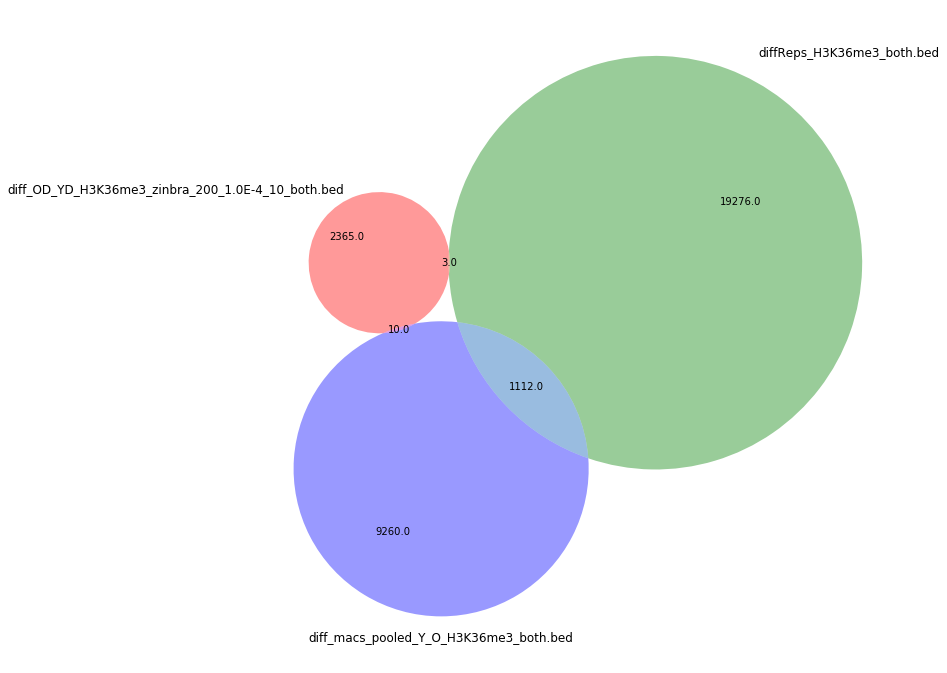

In [46]:
diffs.plot_venn3('diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_10_both.bed', 
                 'diffReps_H3K36me3_both.bed',
                 'diff_macs_pooled_Y_O_H3K36me3_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K36me3/both/diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_10_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K36me3/both/diffReps_broad_H3K36me3_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K36me3/both/diff_macs_pooled_Y_O_H3K36me3_both.bed >/tmp/tmpk_xq6tv9.tmp/counts.bed


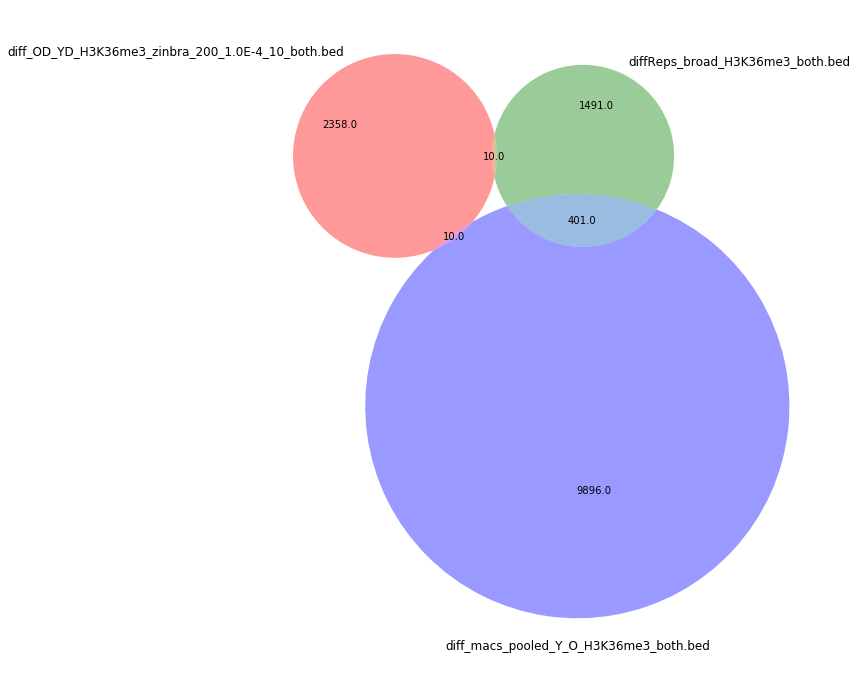

In [47]:
diffs.plot_venn3('diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_10_both.bed',
                 'diffReps_broad_H3K36me3_both.bed',
                 'diff_macs_pooled_Y_O_H3K36me3_both.bed')